In [1]:
# Importing necessary libraries 
import sys
import numpy as np
import emcee
import astropy.io.fits as pyfits

import matplotlib.pylab as pl
import random,os
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
from astropy.io import ascii
import corner
from astropy.table import Column
from astropy.table import join
from IPython.display import clear_output


/Users/suddin/.matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /var/folders/gw/w6qdd1bn6zb2zrvd6dz7_9400000gp/T/matplotlib-762_oa_b because there was an issue with the default path (/Users/suddin/.matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [2]:
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))
os.environ["OMP_NUM_THREADS"] = "1"

12 CPUs


Below is the choice of filter. Filters are: uBgViJH. To run in batchmode uncomment filter = f"{usernames}" and comment out filter = B. Then run the script RunMCMC.ipynb.

In [3]:
np.float = float    
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'

In [4]:
# parameters 
#filter = f"{usernames}" # Run in batchbode
filter='B' # Change here for desired filter 

In [5]:
c = 300000.
q=-0.53

In [6]:
#data
file = filter+'_fastdecliners.csv' # change the filaname here if needed for other bands or for other calibrators
tab = ascii.read('../data/'+file)

st = tab['st']
est = tab['est']
zhel = tab['zhel']
zcmb = tab['zcmb']
mmax = tab['Mmax']
emmax = tab['eMmax']
bv = tab['BV']
ebv = tab['eBV']
dist = tab['dist']
edist = tab['edist']
c_ms = tab['covMs']
c_mbv = tab['covBV_M']
sn = tab['sn']
ebv_host = tab['EBVmw']
Ho_dists = (dist < 0)


In [7]:
#initial guess
plim=-17, -20
p1lim =-10,20
p2lim = -20,20
rvlim =-5,5
siglim=0,1
h0lim= 50.0,100

In [8]:
# Eqn 9 of Bruns 2018
def distmod(h,z1,z2):
    t1 = (1+z1)/(1+z2)
    t2 = (c*z2)/h
    t3 = 1 + (((1-q)/2)*z2)
    return (5*np.log10(t1*t2*t3)) +25


In [9]:
# Liklihood function
def like(par):
    p,p1,rv,sig,h0 = par

    
    if  -25.0<p<-14.0  and -100.0<p1<100.0  and -100.<rv<100.0 and 0<sig<100. and  0< h0 < 1000.0: # priors
                
        mu_obs = mmax - p - p1*(st - 0.5)  - rv*(bv-0.4) #- alpha*(m_csp[w0]-np.median(m_csp[w0]))

        mu_model = np.where(Ho_dists, distmod(h0,zhel,zcmb), dist)

        
        fac = p1
        
        vel = 300 ## chening how it effect rersult

        err = (fac*est)**2 +emmax**2 +(rv*ebv)**2-2*fac*c_ms+rv*c_mbv+sig**2 + +(0.00000723*vel/zcmb)**2#+(alpha*em[w0])**2
        err1 = ((fac*est)**2) +(emmax**2) +((rv*ebv)**2)-(2*fac*c_ms)+(rv*c_mbv)+sig**2+(edist**2)#+(alpha*em[w1])**2

        mu_stat = np.where(Ho_dists,err,err1)

        mu_stat=np.sqrt(mu_stat)
        dmu=mu_obs-mu_model
        
        chi =np.sum((dmu)**2/mu_stat**2)
        return -0.5*chi - (0.5*np.sum(np.log(2*np.pi*(mu_stat)**2))) 
    else:
        return -np.inf

In [10]:
# EMCEE
ndim, nwalkers = 5, 60
ssize=1000
burnin = 500


p00 = np.random.rand(nwalkers) * (plim[1] - plim[0]) + plim[0]
p10 = np.random.rand(nwalkers) * (p1lim[1] - p1lim[0]) + p1lim[0]
rv0 = np.random.rand(nwalkers) * (rvlim[1] - rvlim[0]) + rvlim[0]
sig0 = np.random.rand(nwalkers) * (siglim[1] - siglim[0]) + siglim[0]
h00 = np.random.rand(nwalkers) * (h0lim[1] - h0lim[0]) + h0lim[0]

p0 = np.array([p00,p10,rv0,sig0,h00]).T


In [11]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, like)
print ("running mcmc on "+file)
start = time.time()
sampler.run_mcmc(p0,ssize,progress=True)
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
end = time.time()
serial_time = end - start
print ("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))

/var/folders/gw/w6qdd1bn6zb2zrvd6dz7_9400000gp/T/ipykernel_25411/2939525946.py:6: RuntimeWarning: divide by zero encountered in log10
  return (5*np.log10(t1*t2*t3)) +25
/var/folders/gw/w6qdd1bn6zb2zrvd6dz7_9400000gp/T/ipykernel_25411/2413849140.py:18: RuntimeWarning: divide by zero encountered in divide
  err = (fac*est)**2 +emmax**2 +(rv*ebv)**2-2*fac*c_ms+rv*c_mbv+sig**2 + +(0.00000723*vel/zcmb)**2#+(alpha*em[w0])**2


running mcmc on B_fastdecliners.csv


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 21.27it/s]

Mean acceptance fraction: 0.5356333333333334


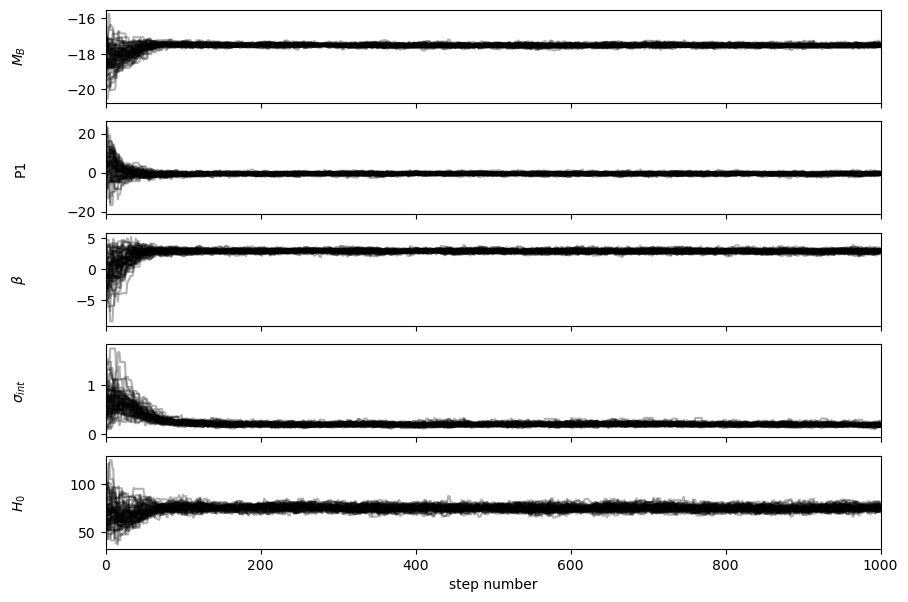

In [12]:
# Chains
clear_output(wait=True)

fig, axes = pl.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$M_B$","P1", r"$\beta$", r"$\sigma_{int}$", r"$H_0$"]
for j in range(ndim):
    ax = axes[j]
    ax.plot(samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

#fig.savefig("../results/trippmethod/"+file[:-4]+"_chains.pdf")
pl.show()

In [13]:
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
#tau = sampler.get_autocorr_time()
#print(tau)

 # Printing results
for i, name in enumerate(labels):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{name}: {mcmc[1]:.3f} (+{q[1]:.3f}/-{q[0]:.3f})")
    
    

$M_B$: -17.525 (+0.069/-0.068)
P1: -0.576 (+0.556/-0.528)
$\beta$: 2.887 (+0.239/-0.251)
$\sigma_{int}$: 0.190 (+0.030/-0.026)
$H_0$: 74.866 (+2.715/-2.551)


In [14]:
# Writing Result
p0_mcmc,p1_mcmc,beta_mcmc,sig_mcmc, H0_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))



#f1 =open('../results/trippmethodLinear/'+file[:-4]+'_result_trippLinear.txt','w') ### MUST change !!

#f1.write('%s\t%s\t%s\t%s\t%s\n'%('p0','p1','beta','sig_int','H0'))
#f1.write('%.3f\t%.3f\t%.3f\t%.3f\t%.3f\n'%(p0_mcmc[0],p1_mcmc[0],beta_mcmc[0],sig_mcmc[0],H0_mcmc[0]))

#f1.write('%.3f\t%.3f\t%.3f\t%.3f\t%.3f\n'%(p0_mcmc[1],p1_mcmc[1],beta_mcmc[1],sig_mcmc[1],H0_mcmc[1]))
#f1.write('%.3f\t%.3f\t%.3f\t%.3f\t%.3f\n'%(p0_mcmc[2],p1_mcmc[2],beta_mcmc[2],sig_mcmc[2],H0_mcmc[2]))
#f1.close()

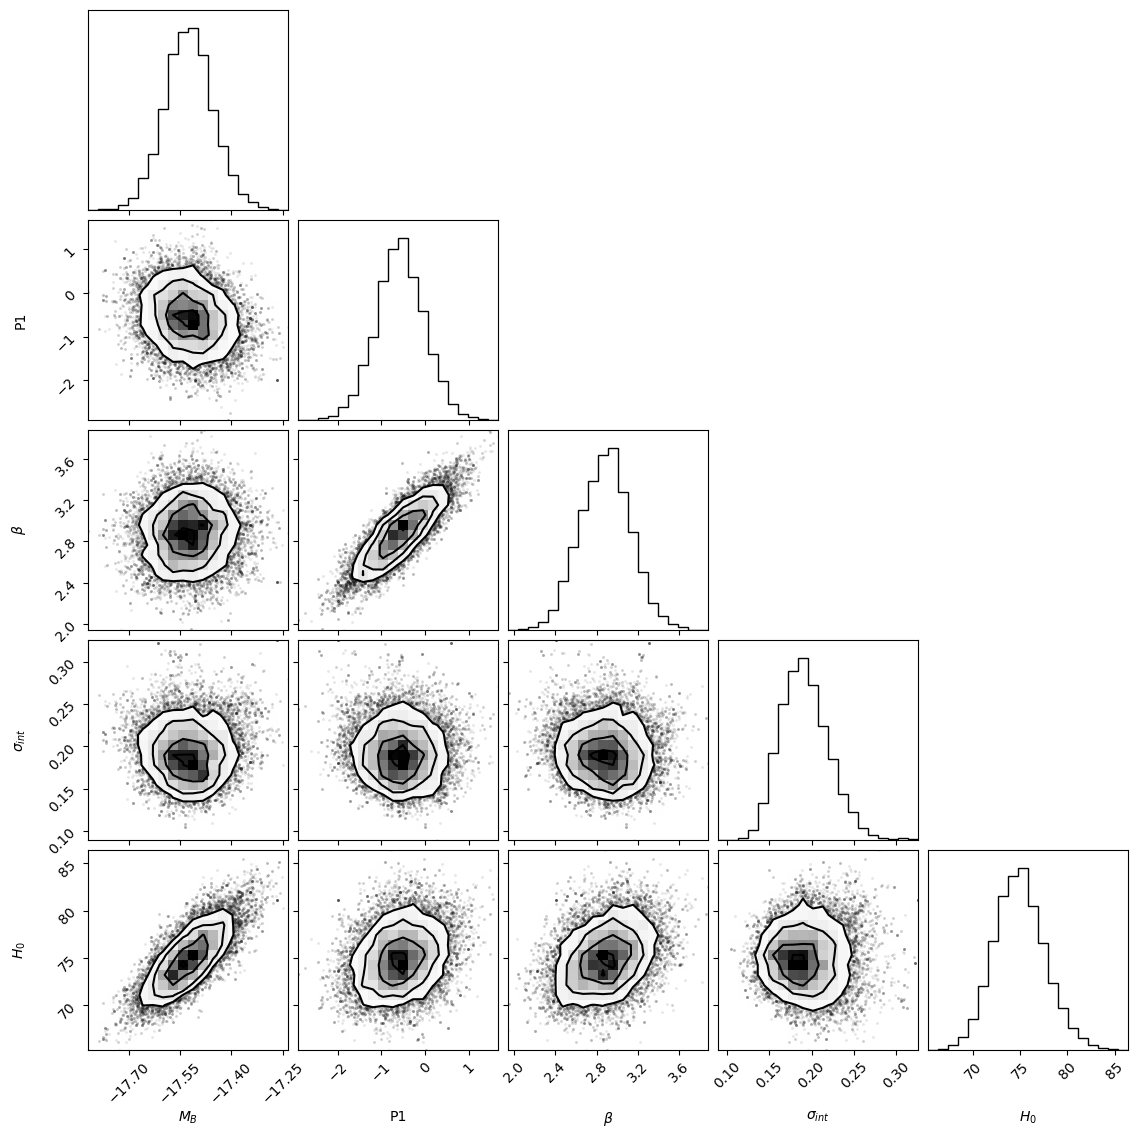

In [15]:
# Triangle plot
clear_output(wait=True)

figure = corner.corner(samples, labels = ["$M_B$","P1",r"$\beta$", r"$\sigma_{int}$", r"$H_0$"])
#figure.savefig("../results/trippmethodLinear/"+file[:-4]+"_trippLinear"+str(nwalkers)+"_"+str(ssize)+".pdf")
pl.show()

In [16]:
import os

os.system('say "your program has finished."')


0